# SIA Analysis

In [1]:
import sys
import os;os.chdir('../')
import itertools as it
import numpy as np
import pandas as pd
import pylab as py
import matplotlib.pyplot as plt
from  matplotlib import rc
from matplotlib.colors import LogNorm
%matplotlib inline
from tools.tools import save,load,lprint
from tools.config import load_config, conf
from tools.bar import BAR
from fitlab.resman import RESMAN
from fitlab.parman import PARMAN
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)

In [2]:
load_config('inputs/sia_kemal.py')
conf['resman']=RESMAN()
conf['parman']=PARMAN()
conf['resman'].get_residuals(conf['parman'].par);

loading sia data sets 2009
multiprocess setup: ncpus=1 / observable


## Load Data from Files

In [3]:
ALL=pd.concat([pd.DataFrame(conf['resman'].siares.tabs[idx]) \
              for idx in conf['resman'].siares.tabs.keys()])

ALL.columns

Index([          u'N',           u'Q',          u'Q2',     u'S2/1+C2',
           u'S2/1-C2',       u'Shift',       u'alpha',         u'col',
          u'dS2/1-C2',         u'dqT',         u'dz1',         u'dz2',
           u'hadron1',     u'hadron2',           u'i',         u'obs',
                u'pT',       u'pTmax',       u'pTmin',          u'qT',
       u'r-residuals',   u'residuals',       u'shift',      u'stat_u',
             u'sys_u',       u'syt_u',         u'thy',       u'value',
                u'z1',       u'z1max',       u'z1min',          u'z2',
             u'z2max',       u'z2min'],
      dtype='object')

## Split Data
Organize data from different collaborations with different observables

In [4]:
data = {}
collaborations = np.unique(ALL.col)

for collab in collaborations:
    data[collab] = {}
    
    data_subset = ALL[ALL.col == collab]
    observables = np.unique(data_subset.obs)
    
    for observable in observables:        
        data[collab][observable] = data_subset[data_subset.obs == observable]        
        print('Collaboration: %s, Observerable: %s, Points: %d' % (collab, observable, len(data[collab][observable])))

Collaboration: BaBaR, Observerable: AUC-0-PT, Points: 9
Collaboration: BaBaR, Observerable: AUC-0-PT-INT, Points: 84
Collaboration: BaBaR, Observerable: AUL-0-PT, Points: 9
Collaboration: BaBaR, Observerable: AUL-0-PT-INT, Points: 84
Collaboration: belle, Observerable: AUC-0-PT-INT, Points: 16
Collaboration: belle, Observerable: AUL-0-PT-INT, Points: 16


## Start Plotting 
Below we plot the data vs. theory curves

In [5]:
plt.rc('font', family='serif')
plt.rc('font', size=16)

In [6]:
# from the paper https://arxiv.org/pdf/1309.5278.pdf
z1_bins = np.array([0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9])

In [7]:
def plot(data):

    n_col = 3
    n_row = len(z1_bins)/n_col + 1

    plt.figure(figsize=(4 *n_col, 3 *n_row))

    for index in range(len(z1_bins)-1):
        data_auc = data['AUC-0-PT-INT'].query('z1 > %f and z1 < %f' % (z1_bins[index], z1_bins[index+1]))
        data_aul = data['AUL-0-PT-INT'].query('z1 > %f and z1 < %f' % (z1_bins[index], z1_bins[index+1]))


        plt.subplot(n_row, n_col, index+1)
        plt.errorbar(data_auc.z2, data_auc.value, data_auc.alpha, 
                    marker='o', linestyle='', color='red', label='$A_{UC}$')
        plt.plot(data_auc.z2, data_auc.thy, linestyle='-', color='red')

        plt.errorbar(data_aul.z2, data_aul.value, data_aul.alpha, 
                    marker='o', linestyle='', color='blue', label='$A_{UL}$')
        plt.plot(data_aul.z2, data_aul.thy, linestyle='-', color='blue')
        plt.xlim([0.0, 1.0])
        plt.xlabel('$Z_2$')
        plt.title('$Z_1 \in [%.1f, %.1f]$' % (z1_bins[index], z1_bins[index+1]))
        
        # the legend has theory labels and I dont like them.
        if len(data_auc) > 0 and len(data_aul) > 0:
            handles, labels = plt.gca().get_legend_handles_labels()
            good_handles = []
            good_labels = []
            for handle, label in zip(handles, labels):
                if 'thy' not in label:
                    good_handles.append(handle)
                    good_labels.append(label)
            
            plt.legend(good_handles, good_labels, frameon=False, loc='topleft')
        
    plt.tight_layout()

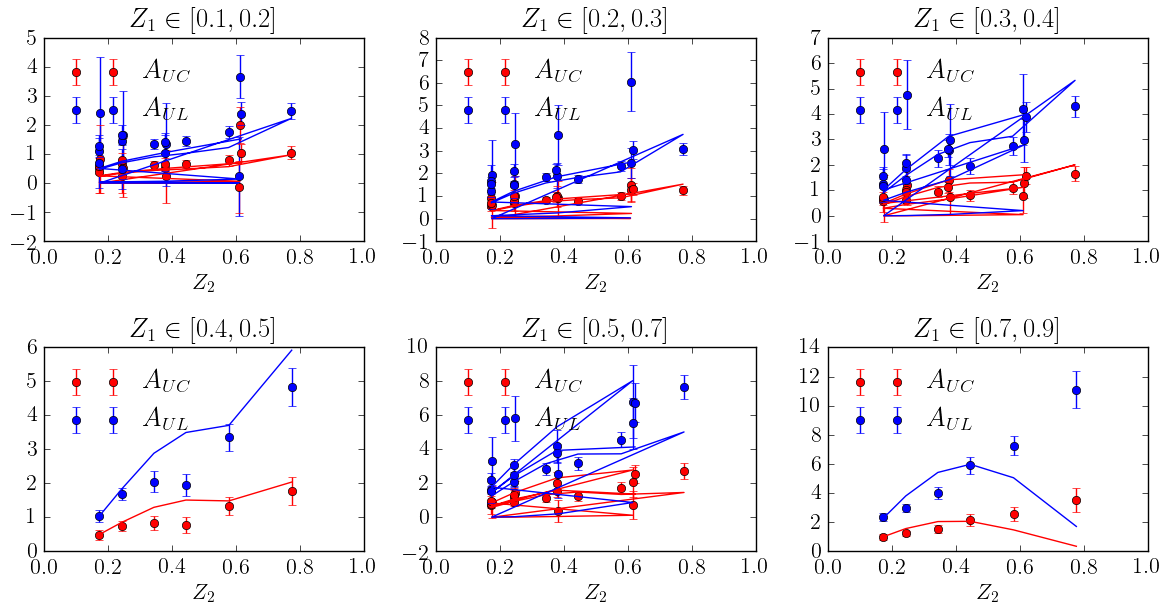

In [8]:
plot(data['BaBaR'])
plt.savefig('sia_babar_kaon.pdf')

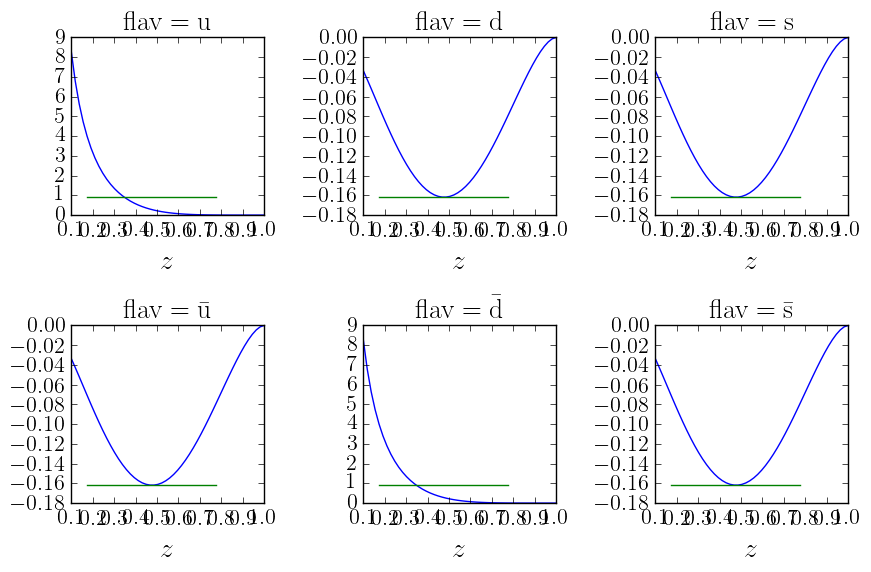

In [12]:
def plot_ff(ax,iflav):
    Z=np.linspace(0.1,1)
    Q2=1
    ZF=[conf['collins'].get_C(z,Q2,hadron='pi+')[iflav] for z in Z]
    ax.plot(Z,ZF)
    if iflav==1: ax.set_title(r'${\rm flav=u}$',size=20)
    if iflav==3: ax.set_title(r'${\rm flav=d}$',size=20)
    if iflav==5: ax.set_title(r'${\rm flav=s}$',size=20)
    if iflav==2: ax.set_title(r'${\rm flav=\bar{u}}$',size=20)
    if iflav==4: ax.set_title(r'${\rm flav=\bar{d}}$',size=20)
    if iflav==6: ax.set_title(r'${\rm flav=\bar{s}}$',size=20)
    ax.set_xlabel(r'$z$',size=20)
    zmin=np.amin(data['BaBaR']['AUC-0-PT-INT'].z1)
    zmax=np.amax(data['BaBaR']['AUC-0-PT-INT'].z1)
    ymin,ymax=ax.get_ylim()
    dy=ymax-ymin
    ax.plot([zmin,zmax],[ymin+dy*0.1,ymin+dy*0.1],'g-')
    ax.set_ylim(ymin,ymax)
    
nrows,ncols=2,3
py.figure(figsize=(ncols*3,nrows*3))
cnt=0
for iflav in [1,3,5,2,4,6]:
    cnt+=1
    ax=py.subplot(nrows,ncols,cnt)
    plot_ff(ax,iflav)
py.tight_layout()

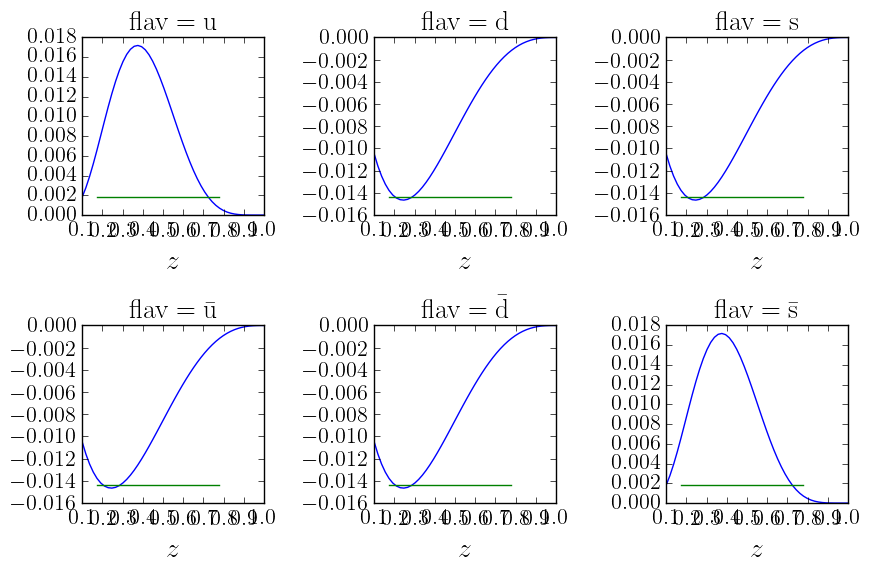

In [9]:
def plot_ff(ax,iflav):
    Z=np.linspace(0.1,1)
    Q2=1
    ZF=[conf['collins'].get_C(z,Q2,hadron='k+')[iflav] for z in Z]
    ax.plot(Z,ZF)
    if iflav==1: ax.set_title(r'${\rm flav=u}$',size=20)
    if iflav==3: ax.set_title(r'${\rm flav=d}$',size=20)
    if iflav==5: ax.set_title(r'${\rm flav=s}$',size=20)
    if iflav==2: ax.set_title(r'${\rm flav=\bar{u}}$',size=20)
    if iflav==4: ax.set_title(r'${\rm flav=\bar{d}}$',size=20)
    if iflav==6: ax.set_title(r'${\rm flav=\bar{s}}$',size=20)
    ax.set_xlabel(r'$z$',size=20)
    zmin=np.amin(data['BaBaR']['AUC-0-PT-INT'].z1)
    zmax=np.amax(data['BaBaR']['AUC-0-PT-INT'].z1)
    ymin,ymax=ax.get_ylim()
    dy=ymax-ymin
    ax.plot([zmin,zmax],[ymin+dy*0.1,ymin+dy*0.1],'g-')
    ax.set_ylim(ymin,ymax)
    
nrows,ncols=2,3
py.figure(figsize=(ncols*3,nrows*3))
cnt=0
for iflav in [1,3,5,2,4,6]:
    cnt+=1
    ax=py.subplot(nrows,ncols,cnt)
    plot_ff(ax,iflav)
py.tight_layout()